# PicToRecipe project

>By Leila Khaertdinova and Karina Denisova

In [2]:
import torchvision
from torchvision import datasets, transforms, models
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from sklearn import preprocessing
import random
import numpy as np
import matplotlib.pyplot as plt

## Dataset loading

In [2]:
# train_data = datasets.Food101(
#     root="data",
#     split="train",
#     download=True,
#     transform=transforms.ToTensor()
# )

# test_data = datasets.Food101(
#     root="data",
#     split="test",
#     download=True,
#     transform=transforms.ToTensor()
# )

100%|██████████| 4996278331/4996278331 [2:24:07<00:00, 577759.85it/s]  


Extracting data/food-101.tar.gz to data


NameError: name 'train_data' is not defined

In [6]:
ds_path = "./data/food-101"
print(os.listdir(ds_path))

['meta', 'README.txt', 'license_agreement.txt', 'images']


In [7]:
# display the content of readme file
!cat {ds_path}/README.txt

Readme

Structure:
----------
pec/
    images/
        <class_name>/
            <image_id>.jpg
    meta/
        classes.txt
        labels.txt
        test.json
        test.txt
        train.json
        train.txt

All images can be found in the "images" folder and are organized per class. All
image ids are unique and correspond to the foodspotting.com review ids. Thus
the original articles can retrieved trough
  http://www.foodspotting.com/reviews/<image_id>
or through the foodspotting api (http://www.foodspotting.com/api).

The test/train splitting used in the experiment of our paper, can be found in
the "meta" directory.

For any questions contact bossard@vision.ee.ethz.ch



In [8]:
# extract the file content having absolute filepath and return it as an array
def extract_file_content(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content.split("\n")[:-1]

In [9]:
# get the classes
classes = extract_file_content(ds_path + "/meta/classes.txt")

if len(classes) == 101:
    print("All food categories (classes) are extracted!")
else:
    print("Something went wrong.")

All food categories (classes) are extracted!


In [10]:
# encode the classes
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(classes)

In [11]:
# extract the pathnames of files with test and train images
train_pathnames = extract_file_content(ds_path + "/meta/train.txt")
test_pathnames = extract_file_content(ds_path + "/meta/test.txt")

# if len(train_pathnames) == len(train_data) and len(test_pathnames) == len(test_data):
#     print("Pathnames of both train and test image sets are correctly extracted!")
# else:
#     print("Something went wrong with train and test pathnames.")

In [12]:
# define a class for an image dataset
class ImageDataset(Dataset):
    def __init__(self, img_pathnames, transform=None, aug_transform=None):
        self.img_pathnames = img_pathnames
        self.transform = transform
        self.aug_transform = aug_transform

    def __len__(self):
        return len(self.img_pathnames)

    def __getitem__(self, i):
        img_path = "./data/food-101/images/" + self.img_pathnames[i] + ".jpg"
        image = Image.open(img_path)
        label = encoder.transform([img_path.split("/")[-2]])[0]

        if self.transform:
            image = self.transform(image)

        if self.aug_transform:
            image = self.aug_transform(image)

        return image, label

In [9]:
min_h, min_w = 200, 200

# data preprocessing
transform = transforms.Compose([
    transforms.Resize((min_h, min_w)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# put data augmentation
data_augmentation = transforms.Compose([
    transforms.RandomApply(torch.nn.ModuleList([
        transforms.RandomRotation((-15, 15), fill=1),
        transforms.RandomHorizontalFlip(p=0.6)
    ]), p = 0.75)
])

# split the train images to train (80%) and validation (20%)
split = int(len(train_pathnames) * 0.8)
random.shuffle(train_pathnames)
train_pathnames, val_pathnames = train_pathnames[:split], train_pathnames[split:]

train_dataset = ImageDataset(train_pathnames,
                             transform=transform,
                             aug_transform=data_augmentation)

# define validation data set and apply preprocessing
val_dataset = ImageDataset(val_pathnames,
                           transform=transform)

# define test data set and apply preprocessing
test_dataset = ImageDataset(test_pathnames,
                            transform=transform)

In [10]:
train_batch_size, test_batch_size, val_batch_size = 64, 64, 64

# define the loader of train data set
train_dataloader = DataLoader(train_dataset,
                               batch_size=train_batch_size,
                               shuffle=True)

# define the loader of train data set
val_dataloader = DataLoader(val_dataset,
                            batch_size=val_batch_size)

# define the loader of test data set
test_dataloader = DataLoader(test_dataset,
                             batch_size=test_batch_size)

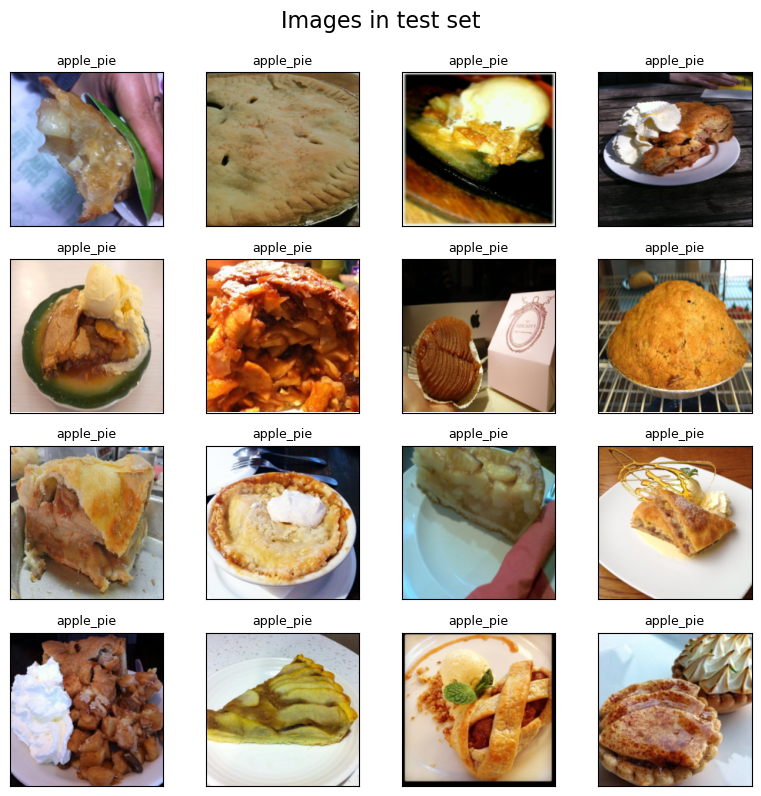

In [11]:
# get one batch of test set images
images, labels = next(iter(test_dataloader))

# check the results of preprocessing
fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    img = images[i] / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=9)

plt.suptitle('Images in test set',
             fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

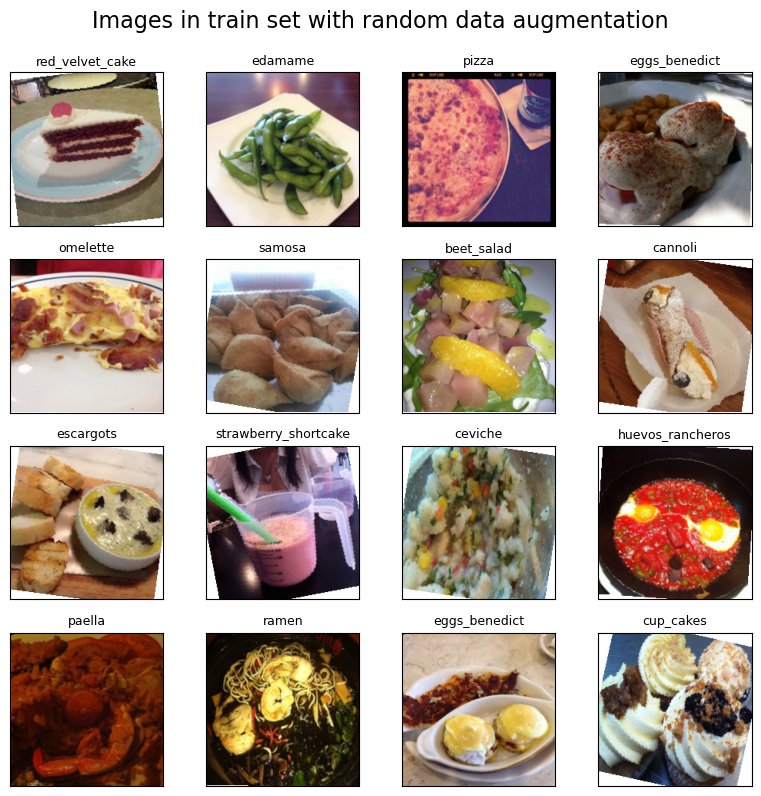

In [12]:
# check the results of preprocessing and data augmentation

# get one batch of train images
images, labels = next(iter(train_dataloader))

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    img = images[i] / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=9)

plt.suptitle('Images in train set with random data augmentation',
             fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

## Model

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model = model.to(device)


print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/karinochka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/karinochka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.SGD(model.parameters(), lr = 0.1)   

In [ ]:
num_epochs = 10

def train(model, loss_func, optimizer, num_epochs):
   for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:

In [18]:
def train(model, train_loader, val_loader, loss_func, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(batch_losses)
        print(f"Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}")
        model.eval()
        batch_losses = []
        trace_y = []
        trace_yhat = []
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            batch_losses.append(loss.item())
            trace_y.append(labels.cpu().detach().numpy())
            trace_yhat.append(outputs.cpu().detach().numpy())
        val_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print(f"Epoch - {epoch} Val-Loss : {np.mean(val_losses[-1])} Val-Accuracy : {accuracy}")
    return train_losses, val_losses

# train the model
train_losses, val_losses = train(resnet, train_dataloader, val_dataloader, loss_func, optimizer, epochs=10)
num_epochs = 10

def train(num_epochs, cnn, train_loader, val_loader):

    cnn.train()

    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 20 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

       # Evaluate on the validation data
        cnn.eval()
        correct = 0
        total = 0
        for images, labels in val_loader:
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = cnn(b_x)[0]
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print('Epoch [{}/{}], Validation Accuracy: {:.2f}%'.format(epoch+1, num_epochs, accuracy))

        cnn.train()              

train(num_epochs, resnet, train_dataloader, val_dataloader)


## write train function with validation based on previous code





KeyboardInterrupt: 

In [ ]:
# cuda = True
epochs = 10
# model_name = 'resnet50.pt'
model_name = 'densenet161.pt'

def train(model, train_loader, val_loader, optimizer, scheduler, model_name, epochs):

    early_stop_count = 0
    early_stop_patience = 5
    best_acc = 0.0

    for epoch in range(epochs):

        # training
        model.train()
        correct = 0
        train_loss = 0.0
        tbar = tqdm(train_loader, desc='Training', position=0, leave=True)
        for i, data in enumerate(tbar):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss

            outputs = outputs.argmax(dim=1)
            correct += (outputs == labels).sum().item()
            acc = 100.0 * correct / ((i + 1) * train_loader.batch_size)
            tbar.set_description(f'Epoch: {epoch + 1}, loss: {loss.item():.4f}, accuracy: {acc:.4f}%')

        train_acc = 100.0 * correct / len(train_loader.dataset)
        train_loss /= (len(train_loader.dataset) / batch_size)

        # validation
        model.eval()
        with torch.no_grad():
            correct = 0
            val_loss = 0.0
            vbar = tqdm(val_loader, desc='Validation', position=0, leave=True)
            for data in vbar:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels)
                outputs = outputs.argmax(dim=1)
                correct += (outputs == labels).sum().item()

            val_acc = 100.0 * correct / len(val_loader.dataset)
            val_loss /= (len(val_loader.dataset) / batch_size)

        print(f'\nEpoch: {epoch + 1}/{epochs}')
        print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
        print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}\n')

        scheduler.step(val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model, model_name)
            early_stop_count = 0
            print('Accuracy improved, model saved.\n')
        else:
            early_stop_count += 1

        if early_stop_count == early_stop_patience:
            print('Early stopping initiated...')
            print(f'Best accuracy achieved: {best_acc:.4f}% at epoch:{epoch - early_stop_patience}')
            print(f'Model saved as {model_name}')
            break


train(model, train_dataloader, val_dataloader, optimizer, scheduler, model_name, epochs)

# write test function for test data
def test(model, test_loader):
    model.eval()
    correct = 0
    test_loss = 0.0
    tbar = tqdm(test_loader, desc='Testing', position=0, leave=True)
    for data in tbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        test_loss += criterion(outputs, labels)
        outputs = outputs.argmax(dim=1)
        correct += (outputs == labels).sum().item()

    test_acc = 100.0 * correct / len(test_loader.dataset)
    test_loss /= (len(test_loader.dataset) / batch_size)

    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

test(model, test_dataloader)

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        # training loop
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
          # Move data and target tensors to the default device
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        train_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/ {num_epochs}, Training Loss: {train_loss:.4f}")

        # validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
              # Move data and target tensors to the default device
                data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        print(f"Epoch {epoch + 1}/ {num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {100 * val_acc:.2f}%")

train(model, train_dataloader, val_dataloader, optimizer, loss_func, num_epochs=10)


In [ ]:
def get_label_of_one_pic(image, model):
    image = image.cuda()
    output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()